In [4]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190618_0806.JF02T09V02.res.h5"
#pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190124_2035.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

Dimensions of G:  (4, 4608, 1024)


In [3]:
DIR = "/sf/alvra/data/p17589/raw/test_watcher/"
#DIR = "/sf/alvra/data/p17803/raw/"

DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

!ls -lah -t /sf/alvra/data/p17589/raw/test_watcher/
#!ls -lah -t /sf/alvra/data/p17803/raw/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 116G
drwxrws---. 13 root  p17589 4.0K Jun 26 14:23 ..
drwxrwsr-x.  2 17589 p17589 4.0K Jun 18 08:29 .
-rw-r--r--.  1 root  p17589 5.2K Jun 18 08:28 run_000038.BSREAD.h5
-rw-r--r--.  1 root  p17589 4.0K Jun 18 08:28 run_000038.BSREAD.h5.err
-rw-r--r--.  1 root  p17589 5.2K Jun 18 08:28 run_000037.BSREAD.h5
-rw-r--r--.  1 root  p17589 4.0K Jun 18 08:28 run_000037.BSREAD.h5.err
-rw-r--r--.  1 17589 p17589 8.8G Jun 18 08:27 run_000038.JF02T09V02.h5
-rw-r--r--.  1 root  p17589  45K Jun 18 08:27 run_000038.BSREAD_CA.h5
-rw-r--r--.  1 root  p17589  46K Jun 18 08:27 run_000037.BSREAD_CA.h5
-rw-r--r--.  1 root  p17589 5.2K Jun 18 08:27 run_000036.BSREAD.h5
-rw-r--r--.  1 root  p17589 4.0K Jun 18 08:27 run_000036.BSREAD.h5.err
-rw-r--r--.  1 17589 p17589 8.8G Jun 18 08:27 run_000037.JF02T09V02.h5
-rw-r--r--.  1 17589 p17589 8.8G Jun 18 08:26 run_000036.JF02T09V02.h5
-rw-r--r--.  1 root  p17589 387M Jun 17 17:59 run_000035.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Jun 17 17:58 run_000035.J

<HDF5 file "run_000038.JF02T09V02.h5" (mode r)>
(1000, 4608, 1024)
(514, 9318)


<IPython.core.display.Javascript object>


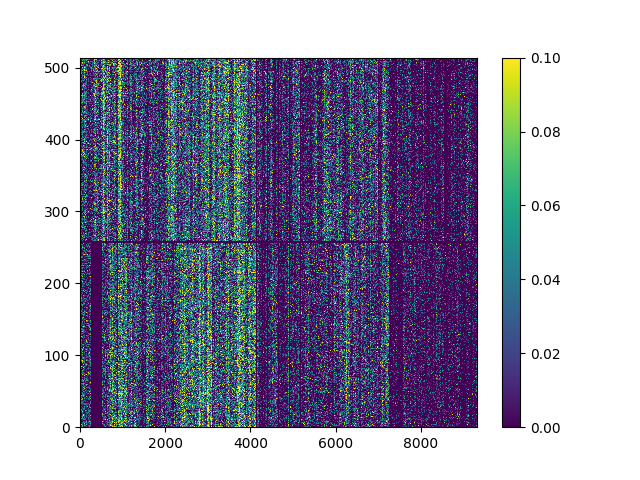

In [4]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "run_000038.JF02T09V02.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)

print(jf_file)

images = jf_file[channel_JF_images]
pulse_ids = jf_file[channel_JF_pulse_ids]
print (images.shape)

nframes = 100
#nframes=images.shape(0)

total = 0

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)#[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes
total_corr = ju.apply_geometry(total,'JF02T09V02')
print (total_corr.shape)

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.imshow(total_corr, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [5]:
# Ka emission 
roi1 = [[200, 300], [6900, 7100]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
# Kb emission 
roi2 = [[200, 300], [8300, 8450]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# The next cell is to analyse a single file within a scan

In [6]:
DIR = "/sf/alvra/data/p17803/raw/scan_data/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"


sigma_low=2.0
sigma_high=2.5

scan_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011"
file_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011_step0020"
step_number = 20

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
image_ON_2D_roi1=0
image_OFF_2D_roi1=0

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
numFiles = 1
print ("Processing",numFiles,"files")

JF_single_file = DIR + file_name + ".JF02T09V01.h5"
BS_single_file = DIR + file_name + ".BSREAD.h5"

print("Processing file %s" % (JF_single_file))

(image_roi1_ON,image_roi1_OFF, pulseIDs) = load_JF_data_pp_pulseID(str(data['scan_files'][step_number][1]), 25, 12.5)


print ("Job done! It took",round((time.time() - start_time),2),"seconds to process the file")


/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011_scan_info.json
Processing 1 files
Processing file /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011_step0020.JF02T09V01.h5


KeyError: 'Unable to open object (component not found)'